In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
import matplotlib as mpl

In [2]:
marker_pos = [np.array([1, 0]), np.array([1, 0.5]), np.array([1, -0.5]),
                          np.array([0, 1]), np.array([0.5, 1]), np.array([-0.5, 1]),
                          np.array([-1, 0]), np.array([-1, 0.5]), np.array([-1, -0.5]),
                          np.array([0, -1]), np.array([0.5, -1]), np.array([-0.5, -1])]

In [3]:
class robot:
    def __init__(x,z,orientation):
        self.x = x
        self.z = z
        self.orientation = orientation
    def update_pos(self, x, z, orientation):
        self.x = x
        self.z = z
        self.orientation = orientation

In [78]:
X = [(i[0]+1)*10 for i in marker_pos]
Y = [(i[1]+1) * 10 for i in marker_pos]

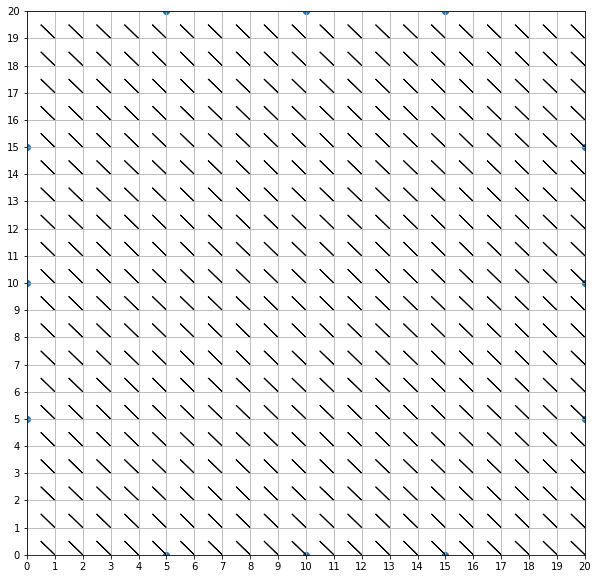

In [90]:
plt.figure(figsize=(10, 10))
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.xticks(np.arange(0,21,1))
plt.yticks(np.arange(0,21,1))

for i in range(0,21):
    for j in range(0,21):
        plt.arrow(i,j,-0.5,0.5)

plt.scatter(X,Y)
plt.grid()

In [226]:
class Environment:
    def __init__(self, shape):
        self.Grid = np.zeros(shape)
        self.grid_shape = shape
        self.marker_pos = [np.array([1, 0]), np.array([1, 0.5]), np.array([1, -0.5]),
                          np.array([0, 1]), np.array([0.5, 1]), np.array([-0.5, 1]),
                          np.array([-1, 0]), np.array([-1, 0.5]), np.array([-1, -0.5]),
                          np.array([0, -1]), np.array([0.5, -1]), np.array([-0.5, -1])]
        
        self.linear_motion_end_prob = [0.7, 0.3]
        
        self.sleep_time = 5
        self.detection_rotation_motion_time = 0.9
        self.random_rotate_max_time = 3.6
        self.translation_max_time = 2.7
        
        self.timet = 1
        
        self.stdz = [1, 0, -1, 0]
        self.stdx = [0, 1, 0, -1]
        self.shiftz = [0, 1, 0, -1]
        self.shiftx = [-1, 0, 1, 0]
        
        self.stdz_diag = [1, -1, -1, 1]
        self.stdx_diag = [1, 1, -1, -1]
        
        self.create_detection_matrix()
        
        
    def create_detection_matrix(self):
        self.detection_prob_matrix = np.ones((20,20,8))
    
    def is_detection(self, robo_state):
        val = self.detection_prob_matrix[robo_state[0], robo_state[1], robo_state[2]]
        probs = [1.0-val, val]
        return np.random.choice([0,1], p = probs)
    
    def mark_cells(self, old_state, new_state, num_steps):
        
        self.Grid[new_state[0], new_state[1]] = 1
        
        if num_steps == 1:
            return
        
        orient = old_state[2]
        if orient in [0,2,4,6]:
            index = int(orient/2)
            self.Grid[old_state[0]+self.stdx[index], old_state[1]+self.stdz[index]] = 1
            self.Grid[old_state[0]+2*self.stdx[index], old_state[1]+2*self.stdz[index]] = 1
        else:
            index = int((orient-1)/2)
            self.Grid[old_state[0]+self.stdx_diag[index], old_state[1]+self.stdz_diag[index]] = 1
            
        
    
    def move_front(self,robo_state, steps):
        current = robo_state
        orient = robo_state[2]
        if orient in [0,2,4,6]:
            index = orient/2
            index = int(index)
            #print(index)
            options = []
            cand1 = np.array([current[0]+steps*self.stdx[index],  current[1]+steps*self.stdz[index], orient])
            if not self.boundary(cand1[0], cand1[1]):
                options.append(cand1)
            else:
                return None
            
            cand2 = np.array([current[0]+3*self.stdx[index] + self.shiftx[index],  current[1]+3*self.stdz[index] + self.shiftz[index], (orient-1+8)%8])
            if not self.boundary(cand2[0], cand2[1]):
                options.append(cand2)
                
            if len(options)==2:
                new_state_index = np.random.choice(np.arange(len(options)), p=self.linear_motion_end_prob)
                new_state = options[new_state_index]
            else:
                new_state = options[0]
        
        
        else:
            index = (orient - 1)/2
            index = int(index)
            if steps == 3:
                steps = 2
                
            cand = np.array([current[0]+steps*self.stdx_diag[index], current[1]+steps*self.stdz_diag[index], orient])
            
            if not self.boundary(current[0]+steps*self.stdx_diag[index], current[1]+steps*self.stdz_diag[index]):
                new_state = cand
            else:
                return None
        
        return new_state
    
    
    def random_rotate(self, robo_state):
        orient = robo_state[2]
        if orient == 0:
            return np.random.choice([2,3,4,5,6])
        if orient == 2:
            return np.random.choice([4,5,6,7,0])
        if orient == 4:
            return np.random.choice([0,1,2,6,7])
        if orient == 6:
            return np.random.choice([0,1,2,3,4])
        
        if orient == 1:
            return np.random.choice([4,5,6])
        if orient == 3:
            return np.random.choice([0,6,7])
        if orient == 5:
            return np.random.choice([0,1,2])
        if orient == 7:
            return np.random.choice([2,3,4])
            
    def manage_motion(self, time_allowed, robo_state):
        
        while self.timet < time_allowed:
            new_state = self.move_front(robo_state, 3)
            if new_state is None:
                new_state = self.move_front(robo_state, 1)
                if new_state is None:
                    new_orient = self.random_rotate(robo_state)
                    self.timet = self.timet + self.random_rotate_max_time
                    robo_state[2] = new_orient
                    continue
                else:
                    self.mark_cells(robo_state, new_state,1)
                    self.timet = self.timet + self.translation_max_time
                    self.timet = self.timet + self.sleep_time
                    #print("iter:{0}.  moved to {1}".format(itert, new_state))
            else:
                self.mark_cells(robo_state, new_state,3)
                self.timet = self.timet + self.translation_max_time
                self.timet = self.timet + self.sleep_time
                #print("iter:{0}.  moved to {1}".format(itert, new_state))
            
            
            
            robo_state = new_state
            
            for i in range(5):
                if not self.is_detection( robo_state):
                    robo_state[2] = (robo_state[2] + 1) % 8
                    self.timet = self.timet + self.detection_rotation_motion_time
                    self.timet = self.timet + self.sleep_time
                else:
                    break
    
    
    def manage_motion_iters(self, iters, robo_state):
        
        for i in range(iters):
            new_state = self.move_front(robo_state, 3)
            if new_state is None:
                new_state = self.move_front(robo_state, 1)
                if new_state is None:
                    new_orient = self.random_rotate(robo_state)
                    self.timet = self.timet + self.random_rotate_max_time
                    robo_state[2] = new_orient
                    continue
                else:
                    self.mark_cells(robo_state, new_state,1)
                    self.timet = self.timet + self.translation_max_time
                    self.timet = self.timet + self.sleep_time
                    #print("iter:{0}.  moved to {1}".format(itert, new_state))
            else:
                self.mark_cells(robo_state, new_state,3)
                self.timet = self.timet + self.translation_max_time
                self.timet = self.timet + self.sleep_time
                #print("iter:{0}.  moved to {1}".format(itert, new_state))
            
            
            
            robo_state = new_state
            
            for i in range(5):
                if not self.is_detection( robo_state):
                    robo_state[2] = (robo_state[2] + 1) % 8
                    self.timet = self.timet + self.detection_rotation_motion_time
                    self.timet = self.timet + self.sleep_time
                else:
                    break

    
    def boundary(self,x,y):
        if x >= self.grid_shape[0] or y >= self.grid_shape[1] or x<0 or y<0:
            return True
        else:
            return False
        
        
    def display_grid(self):
        plt.figure(figsize = (10,10))
        plt.imshow(self.Grid.T, cmap='binary', interpolation='nearest')
        plt.show()
        
    def display_grid2(self):
        color_map = mpl.colors.ListedColormap(['b', 'w'])
        # create a normalize object the describes the limits of
        # each color
        bounds = [0., 0.5, 1.]
        norm = mpl.colors.BoundaryNorm(bounds, color_map.N)
        # plot it
        plt.imshow(self.Grid, interpolation='none', cmap=color_map, norm=norm)

        
    def percentage_area_covered(self):
        area_covered = np.sum(np.sum(self.Grid))
        print("Area covered: {0}%".format((area_covered/400)*100))
        return (area_covered/400)*100

In [215]:
env = Environment((20,20))

In [190]:
time_allowed = 300

In [191]:
env.Grid[15,5] = 1
env.manage_motion(time_allowed, np.array([15,5,0]))

In [192]:
env.percentage_area_covered()

Area covered: 13.5%


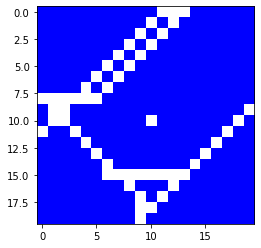

In [194]:
env.display_grid2()
# white - covered
# blue - not covered

In [193]:
env.timet

307.4999999999998

In [216]:
time_allowed = 300

In [217]:
area_covered_list_300 = []

In [218]:
for i in range(10000):
    env = Environment((20,20))
    env.Grid[15,5] = 1
    env.manage_motion(time_allowed, np.array([15,5,0]))
    area_covered_list_300.append(env.percentage_area_covered())

Area covered: 13.750000000000002%
Area covered: 18.5%
Area covered: 11.25%
Area covered: 14.000000000000002%
Area covered: 17.5%
Area covered: 16.5%
Area covered: 19.25%
Area covered: 17.75%
Area covered: 16.0%
Area covered: 19.5%
Area covered: 16.5%
Area covered: 16.0%
Area covered: 20.25%
Area covered: 19.0%
Area covered: 17.25%
Area covered: 6.5%
Area covered: 20.5%
Area covered: 15.75%
Area covered: 18.5%
Area covered: 21.0%
Area covered: 17.0%
Area covered: 19.5%
Area covered: 14.249999999999998%
Area covered: 17.75%
Area covered: 16.25%
Area covered: 18.75%
Area covered: 17.0%
Area covered: 13.0%
Area covered: 16.5%
Area covered: 15.25%
Area covered: 21.25%
Area covered: 17.0%
Area covered: 18.75%
Area covered: 22.5%
Area covered: 18.25%
Area covered: 18.5%
Area covered: 14.75%
Area covered: 18.5%
Area covered: 19.75%
Area covered: 14.000000000000002%
Area covered: 17.75%
Area covered: 18.0%
Area covered: 18.5%
Area covered: 15.0%
Area covered: 20.0%
Area covered: 17.75%
Area cov

Area covered: 15.75%
Area covered: 21.75%
Area covered: 18.75%
Area covered: 20.25%
Area covered: 14.75%
Area covered: 15.25%
Area covered: 16.25%
Area covered: 15.75%
Area covered: 14.000000000000002%
Area covered: 20.75%
Area covered: 13.25%
Area covered: 20.25%
Area covered: 19.75%
Area covered: 17.0%
Area covered: 11.5%
Area covered: 19.0%
Area covered: 17.75%
Area covered: 20.5%
Area covered: 15.0%
Area covered: 15.0%
Area covered: 10.5%
Area covered: 11.25%
Area covered: 20.25%
Area covered: 19.5%
Area covered: 18.5%
Area covered: 20.5%
Area covered: 10.5%
Area covered: 17.75%
Area covered: 15.5%
Area covered: 16.25%
Area covered: 14.249999999999998%
Area covered: 10.25%
Area covered: 19.0%
Area covered: 16.75%
Area covered: 14.75%
Area covered: 13.5%
Area covered: 14.000000000000002%
Area covered: 12.75%
Area covered: 12.75%
Area covered: 16.25%
Area covered: 18.5%
Area covered: 12.25%
Area covered: 7.5%
Area covered: 16.75%
Area covered: 23.25%
Area covered: 17.25%
Area covered

Area covered: 14.249999999999998%
Area covered: 19.25%
Area covered: 13.5%
Area covered: 17.0%
Area covered: 19.0%
Area covered: 15.5%
Area covered: 18.25%
Area covered: 20.75%
Area covered: 17.5%
Area covered: 14.499999999999998%
Area covered: 16.25%
Area covered: 18.25%
Area covered: 13.0%
Area covered: 19.0%
Area covered: 12.25%
Area covered: 10.25%
Area covered: 15.0%
Area covered: 21.0%
Area covered: 19.25%
Area covered: 22.0%
Area covered: 18.0%
Area covered: 12.0%
Area covered: 16.0%
Area covered: 21.25%
Area covered: 13.0%
Area covered: 17.5%
Area covered: 17.0%
Area covered: 19.0%
Area covered: 18.25%
Area covered: 7.75%
Area covered: 11.75%
Area covered: 21.0%
Area covered: 17.5%
Area covered: 19.75%
Area covered: 20.25%
Area covered: 11.25%
Area covered: 16.75%
Area covered: 18.5%
Area covered: 12.25%
Area covered: 11.75%
Area covered: 22.0%
Area covered: 14.499999999999998%
Area covered: 18.0%
Area covered: 15.0%
Area covered: 20.5%
Area covered: 18.0%
Area covered: 14.0000

Area covered: 12.25%
Area covered: 15.75%
Area covered: 17.5%
Area covered: 10.0%
Area covered: 15.25%
Area covered: 20.75%
Area covered: 17.0%
Area covered: 17.25%
Area covered: 17.75%
Area covered: 14.249999999999998%
Area covered: 17.5%
Area covered: 15.25%
Area covered: 17.25%
Area covered: 16.5%
Area covered: 20.25%
Area covered: 14.499999999999998%
Area covered: 12.5%
Area covered: 20.0%
Area covered: 19.5%
Area covered: 20.5%
Area covered: 19.25%
Area covered: 11.75%
Area covered: 18.75%
Area covered: 18.25%
Area covered: 15.25%
Area covered: 21.0%
Area covered: 17.75%
Area covered: 17.0%
Area covered: 11.25%
Area covered: 15.5%
Area covered: 14.000000000000002%
Area covered: 12.0%
Area covered: 20.25%
Area covered: 19.0%
Area covered: 14.000000000000002%
Area covered: 19.25%
Area covered: 14.499999999999998%
Area covered: 19.0%
Area covered: 21.25%
Area covered: 19.75%
Area covered: 14.499999999999998%
Area covered: 15.5%
Area covered: 18.75%
Area covered: 16.75%
Area covered: 

Area covered: 16.75%
Area covered: 15.0%
Area covered: 19.5%
Area covered: 16.5%
Area covered: 11.5%
Area covered: 18.0%
Area covered: 13.5%
Area covered: 14.75%
Area covered: 12.0%
Area covered: 20.5%
Area covered: 17.75%
Area covered: 12.25%
Area covered: 14.75%
Area covered: 8.0%
Area covered: 15.5%
Area covered: 16.25%
Area covered: 18.75%
Area covered: 17.75%
Area covered: 9.75%
Area covered: 18.5%
Area covered: 14.249999999999998%
Area covered: 20.5%
Area covered: 20.0%
Area covered: 16.5%
Area covered: 21.25%
Area covered: 14.000000000000002%
Area covered: 9.25%
Area covered: 16.5%
Area covered: 12.0%
Area covered: 18.25%
Area covered: 19.0%
Area covered: 12.25%
Area covered: 13.5%
Area covered: 21.5%
Area covered: 16.25%
Area covered: 17.5%
Area covered: 22.5%
Area covered: 15.75%
Area covered: 20.0%
Area covered: 21.5%
Area covered: 17.5%
Area covered: 17.0%
Area covered: 17.75%
Area covered: 10.0%
Area covered: 16.25%
Area covered: 17.5%
Area covered: 19.0%
Area covered: 15.0

Area covered: 21.0%
Area covered: 19.5%
Area covered: 17.75%
Area covered: 21.25%
Area covered: 14.249999999999998%
Area covered: 16.5%
Area covered: 12.75%
Area covered: 16.25%
Area covered: 17.0%
Area covered: 14.000000000000002%
Area covered: 18.0%
Area covered: 16.0%
Area covered: 17.75%
Area covered: 16.75%
Area covered: 20.0%
Area covered: 16.0%
Area covered: 16.75%
Area covered: 17.0%
Area covered: 17.5%
Area covered: 16.5%
Area covered: 15.75%
Area covered: 17.75%
Area covered: 16.75%
Area covered: 17.75%
Area covered: 15.75%
Area covered: 22.0%
Area covered: 16.0%
Area covered: 18.0%
Area covered: 18.25%
Area covered: 20.0%
Area covered: 10.0%
Area covered: 17.25%
Area covered: 13.750000000000002%
Area covered: 17.75%
Area covered: 20.5%
Area covered: 11.25%
Area covered: 15.5%
Area covered: 11.75%
Area covered: 13.0%
Area covered: 13.750000000000002%
Area covered: 15.5%
Area covered: 17.0%
Area covered: 20.5%
Area covered: 18.0%
Area covered: 18.0%
Area covered: 19.25%
Area c

Area covered: 19.75%
Area covered: 19.5%
Area covered: 18.25%
Area covered: 17.5%
Area covered: 17.25%
Area covered: 13.0%
Area covered: 11.25%
Area covered: 13.25%
Area covered: 12.0%
Area covered: 15.75%
Area covered: 14.249999999999998%
Area covered: 16.25%
Area covered: 21.5%
Area covered: 14.249999999999998%
Area covered: 16.0%
Area covered: 13.750000000000002%
Area covered: 16.25%
Area covered: 21.25%
Area covered: 19.5%
Area covered: 15.25%
Area covered: 16.75%
Area covered: 20.0%
Area covered: 15.75%
Area covered: 13.750000000000002%
Area covered: 22.25%
Area covered: 13.25%
Area covered: 11.75%
Area covered: 17.75%
Area covered: 13.0%
Area covered: 17.25%
Area covered: 20.5%
Area covered: 11.25%
Area covered: 12.75%
Area covered: 16.0%
Area covered: 17.25%
Area covered: 15.25%
Area covered: 15.25%
Area covered: 15.25%
Area covered: 19.75%
Area covered: 17.5%
Area covered: 17.75%
Area covered: 15.0%
Area covered: 22.5%
Area covered: 9.25%
Area covered: 16.0%
Area covered: 12.75

Area covered: 19.75%
Area covered: 12.0%
Area covered: 14.249999999999998%
Area covered: 17.5%
Area covered: 18.0%
Area covered: 22.0%
Area covered: 21.0%
Area covered: 20.25%
Area covered: 22.25%
Area covered: 20.25%
Area covered: 13.0%
Area covered: 11.0%
Area covered: 15.75%
Area covered: 17.5%
Area covered: 16.75%
Area covered: 9.0%
Area covered: 13.25%
Area covered: 13.5%
Area covered: 20.5%
Area covered: 18.5%
Area covered: 19.25%
Area covered: 20.75%
Area covered: 21.25%
Area covered: 15.0%
Area covered: 18.5%
Area covered: 15.0%
Area covered: 18.0%
Area covered: 19.0%
Area covered: 17.75%
Area covered: 14.249999999999998%
Area covered: 13.25%
Area covered: 11.0%
Area covered: 20.0%
Area covered: 16.5%
Area covered: 16.25%
Area covered: 15.75%
Area covered: 15.75%
Area covered: 15.0%
Area covered: 19.75%
Area covered: 18.75%
Area covered: 19.25%
Area covered: 9.75%
Area covered: 18.25%
Area covered: 4.75%
Area covered: 18.75%
Area covered: 14.499999999999998%
Area covered: 17.5%

Area covered: 14.499999999999998%
Area covered: 12.75%
Area covered: 12.25%
Area covered: 13.750000000000002%
Area covered: 14.000000000000002%
Area covered: 18.0%
Area covered: 17.25%
Area covered: 14.249999999999998%
Area covered: 15.5%
Area covered: 18.25%
Area covered: 21.0%
Area covered: 14.000000000000002%
Area covered: 17.25%
Area covered: 16.75%
Area covered: 16.5%
Area covered: 10.75%
Area covered: 14.249999999999998%
Area covered: 12.25%
Area covered: 8.75%
Area covered: 18.25%
Area covered: 18.75%
Area covered: 14.000000000000002%
Area covered: 16.75%
Area covered: 21.25%
Area covered: 15.75%
Area covered: 15.75%
Area covered: 8.5%
Area covered: 13.25%
Area covered: 10.75%
Area covered: 16.5%
Area covered: 10.75%
Area covered: 13.0%
Area covered: 11.75%
Area covered: 21.25%
Area covered: 21.0%
Area covered: 21.25%
Area covered: 14.499999999999998%
Area covered: 9.75%
Area covered: 15.75%
Area covered: 18.0%
Area covered: 17.5%
Area covered: 17.0%
Area covered: 20.25%
Area co

Area covered: 11.75%
Area covered: 17.0%
Area covered: 22.0%
Area covered: 14.499999999999998%
Area covered: 16.25%
Area covered: 11.75%
Area covered: 19.5%
Area covered: 22.5%
Area covered: 17.0%
Area covered: 15.5%
Area covered: 16.5%
Area covered: 22.0%
Area covered: 15.75%
Area covered: 14.499999999999998%
Area covered: 14.499999999999998%
Area covered: 19.5%
Area covered: 17.75%
Area covered: 14.000000000000002%
Area covered: 14.499999999999998%
Area covered: 7.75%
Area covered: 15.0%
Area covered: 20.25%
Area covered: 21.25%
Area covered: 18.75%
Area covered: 16.25%
Area covered: 13.5%
Area covered: 17.5%
Area covered: 15.75%
Area covered: 14.000000000000002%
Area covered: 21.25%
Area covered: 22.0%
Area covered: 14.000000000000002%
Area covered: 18.5%
Area covered: 10.75%
Area covered: 14.499999999999998%
Area covered: 16.0%
Area covered: 19.75%
Area covered: 14.000000000000002%
Area covered: 18.5%
Area covered: 21.75%
Area covered: 11.25%
Area covered: 17.5%
Area covered: 17.5%

Area covered: 11.75%
Area covered: 10.25%
Area covered: 18.25%
Area covered: 12.5%
Area covered: 12.25%
Area covered: 15.0%
Area covered: 16.0%
Area covered: 21.5%
Area covered: 19.75%
Area covered: 21.0%
Area covered: 16.0%
Area covered: 18.5%
Area covered: 13.25%
Area covered: 15.5%
Area covered: 12.5%
Area covered: 16.5%
Area covered: 18.25%
Area covered: 17.0%
Area covered: 14.499999999999998%
Area covered: 20.75%
Area covered: 15.75%
Area covered: 21.5%
Area covered: 16.75%
Area covered: 11.75%
Area covered: 18.25%
Area covered: 21.5%
Area covered: 22.75%
Area covered: 21.0%
Area covered: 14.249999999999998%
Area covered: 13.5%
Area covered: 19.25%
Area covered: 17.75%
Area covered: 17.5%
Area covered: 14.75%
Area covered: 11.0%
Area covered: 15.5%
Area covered: 14.499999999999998%
Area covered: 14.000000000000002%
Area covered: 13.750000000000002%
Area covered: 15.0%
Area covered: 14.249999999999998%
Area covered: 19.25%
Area covered: 11.25%
Area covered: 22.5%
Area covered: 21.2

Area covered: 16.0%
Area covered: 22.0%
Area covered: 18.75%
Area covered: 18.5%
Area covered: 13.25%
Area covered: 20.5%
Area covered: 16.25%
Area covered: 21.0%
Area covered: 17.25%
Area covered: 15.0%
Area covered: 15.75%
Area covered: 14.249999999999998%
Area covered: 14.249999999999998%
Area covered: 12.5%
Area covered: 17.75%
Area covered: 10.5%
Area covered: 16.0%
Area covered: 17.5%
Area covered: 12.25%
Area covered: 20.5%
Area covered: 17.25%
Area covered: 18.0%
Area covered: 12.5%
Area covered: 12.75%
Area covered: 19.75%
Area covered: 17.25%
Area covered: 16.75%
Area covered: 11.0%
Area covered: 13.750000000000002%
Area covered: 13.0%
Area covered: 13.25%
Area covered: 17.0%
Area covered: 15.5%
Area covered: 7.000000000000001%
Area covered: 19.25%
Area covered: 16.0%
Area covered: 17.75%
Area covered: 12.5%
Area covered: 18.25%
Area covered: 19.5%
Area covered: 19.75%
Area covered: 12.25%
Area covered: 20.75%
Area covered: 19.0%
Area covered: 13.0%
Area covered: 18.75%
Area 

Area covered: 23.25%
Area covered: 18.25%
Area covered: 13.5%
Area covered: 13.750000000000002%
Area covered: 16.0%
Area covered: 18.75%
Area covered: 11.0%
Area covered: 17.25%
Area covered: 12.0%
Area covered: 19.25%
Area covered: 10.75%
Area covered: 17.5%
Area covered: 21.5%
Area covered: 19.75%
Area covered: 15.25%
Area covered: 19.5%
Area covered: 19.75%
Area covered: 16.75%
Area covered: 14.499999999999998%
Area covered: 12.5%
Area covered: 14.75%
Area covered: 16.75%
Area covered: 21.25%
Area covered: 19.0%
Area covered: 16.25%
Area covered: 19.0%
Area covered: 17.5%
Area covered: 19.5%
Area covered: 14.249999999999998%
Area covered: 19.25%
Area covered: 19.25%
Area covered: 19.5%
Area covered: 10.75%
Area covered: 21.75%
Area covered: 14.499999999999998%
Area covered: 13.5%
Area covered: 15.75%
Area covered: 13.750000000000002%
Area covered: 19.5%
Area covered: 11.75%
Area covered: 13.750000000000002%
Area covered: 4.75%
Area covered: 16.5%
Area covered: 19.75%
Area covered: 2

Area covered: 11.75%
Area covered: 11.25%
Area covered: 23.25%
Area covered: 19.0%
Area covered: 13.25%
Area covered: 14.000000000000002%
Area covered: 23.0%
Area covered: 20.25%
Area covered: 15.5%
Area covered: 21.25%
Area covered: 9.5%
Area covered: 21.25%
Area covered: 13.5%
Area covered: 18.75%
Area covered: 17.75%
Area covered: 13.5%
Area covered: 17.25%
Area covered: 14.000000000000002%
Area covered: 18.0%
Area covered: 13.5%
Area covered: 16.25%
Area covered: 13.0%
Area covered: 15.25%
Area covered: 10.0%
Area covered: 12.25%
Area covered: 13.25%
Area covered: 14.000000000000002%
Area covered: 16.75%
Area covered: 15.25%
Area covered: 21.0%
Area covered: 15.5%
Area covered: 16.0%
Area covered: 16.25%
Area covered: 21.75%
Area covered: 11.25%
Area covered: 21.25%
Area covered: 12.25%
Area covered: 13.25%
Area covered: 17.75%
Area covered: 14.75%
Area covered: 21.25%
Area covered: 16.25%
Area covered: 17.75%
Area covered: 10.75%
Area covered: 20.0%
Area covered: 4.75%
Area covere

Area covered: 14.000000000000002%
Area covered: 11.0%
Area covered: 16.25%
Area covered: 13.5%
Area covered: 17.75%
Area covered: 11.75%
Area covered: 17.75%
Area covered: 19.5%
Area covered: 20.25%
Area covered: 17.25%
Area covered: 17.5%
Area covered: 16.25%
Area covered: 19.75%
Area covered: 16.0%
Area covered: 18.75%
Area covered: 13.0%
Area covered: 21.25%
Area covered: 17.0%
Area covered: 16.5%
Area covered: 20.25%
Area covered: 21.0%
Area covered: 16.5%
Area covered: 22.25%
Area covered: 11.0%
Area covered: 13.750000000000002%
Area covered: 19.5%
Area covered: 15.75%
Area covered: 20.75%
Area covered: 13.5%
Area covered: 19.25%
Area covered: 19.0%
Area covered: 15.5%
Area covered: 15.0%
Area covered: 22.5%
Area covered: 14.499999999999998%
Area covered: 15.75%
Area covered: 19.5%
Area covered: 17.0%
Area covered: 11.75%
Area covered: 19.0%
Area covered: 14.499999999999998%
Area covered: 17.75%
Area covered: 14.499999999999998%
Area covered: 19.5%
Area covered: 6.25%
Area covered

Area covered: 21.5%
Area covered: 17.5%
Area covered: 13.5%
Area covered: 9.5%
Area covered: 14.249999999999998%
Area covered: 19.25%
Area covered: 14.000000000000002%
Area covered: 17.25%
Area covered: 16.25%
Area covered: 21.5%
Area covered: 11.75%
Area covered: 13.25%
Area covered: 16.25%
Area covered: 14.000000000000002%
Area covered: 18.0%
Area covered: 23.75%
Area covered: 22.0%
Area covered: 10.75%
Area covered: 17.75%
Area covered: 17.0%
Area covered: 19.75%
Area covered: 16.0%
Area covered: 13.25%
Area covered: 19.5%
Area covered: 18.5%
Area covered: 15.75%
Area covered: 12.0%
Area covered: 14.000000000000002%
Area covered: 14.75%
Area covered: 8.5%
Area covered: 9.5%
Area covered: 17.5%
Area covered: 12.0%
Area covered: 12.0%
Area covered: 17.5%
Area covered: 15.75%
Area covered: 14.499999999999998%
Area covered: 14.000000000000002%
Area covered: 19.5%
Area covered: 17.5%
Area covered: 20.25%
Area covered: 4.75%
Area covered: 18.25%
Area covered: 13.0%
Area covered: 20.75%
Ar

Area covered: 15.25%
Area covered: 12.5%
Area covered: 14.000000000000002%
Area covered: 22.5%
Area covered: 17.75%
Area covered: 12.5%
Area covered: 10.25%
Area covered: 13.5%
Area covered: 13.750000000000002%
Area covered: 14.249999999999998%
Area covered: 14.499999999999998%
Area covered: 13.0%
Area covered: 22.0%
Area covered: 16.0%
Area covered: 16.25%
Area covered: 15.25%
Area covered: 15.75%
Area covered: 20.25%
Area covered: 19.5%
Area covered: 18.5%
Area covered: 18.75%
Area covered: 14.249999999999998%
Area covered: 16.0%
Area covered: 10.0%
Area covered: 15.5%
Area covered: 17.5%
Area covered: 20.5%
Area covered: 12.5%
Area covered: 13.5%
Area covered: 16.0%
Area covered: 17.25%
Area covered: 17.75%
Area covered: 18.0%
Area covered: 18.5%
Area covered: 17.0%
Area covered: 15.5%
Area covered: 17.0%
Area covered: 15.25%
Area covered: 22.0%
Area covered: 8.75%
Area covered: 19.75%
Area covered: 19.75%
Area covered: 19.5%
Area covered: 22.25%
Area covered: 10.25%
Area covered: 1

Area covered: 17.0%
Area covered: 15.75%
Area covered: 20.0%
Area covered: 9.75%
Area covered: 15.75%
Area covered: 16.25%
Area covered: 19.25%
Area covered: 15.25%
Area covered: 17.25%
Area covered: 14.75%
Area covered: 15.0%
Area covered: 21.75%
Area covered: 17.75%
Area covered: 14.000000000000002%
Area covered: 18.5%
Area covered: 22.0%
Area covered: 17.75%
Area covered: 18.25%
Area covered: 15.0%
Area covered: 17.25%
Area covered: 18.5%
Area covered: 17.5%
Area covered: 18.5%
Area covered: 18.25%
Area covered: 9.0%
Area covered: 14.249999999999998%
Area covered: 20.5%
Area covered: 14.499999999999998%
Area covered: 16.5%
Area covered: 18.75%
Area covered: 14.75%
Area covered: 17.75%
Area covered: 13.5%
Area covered: 18.75%
Area covered: 18.75%
Area covered: 4.75%
Area covered: 17.75%
Area covered: 18.5%
Area covered: 13.25%
Area covered: 13.750000000000002%
Area covered: 15.25%
Area covered: 16.25%
Area covered: 18.75%
Area covered: 19.0%
Area covered: 9.25%
Area covered: 19.25%
A

Area covered: 13.5%
Area covered: 16.0%
Area covered: 16.75%
Area covered: 17.5%
Area covered: 19.75%
Area covered: 15.5%
Area covered: 17.75%
Area covered: 8.0%
Area covered: 16.75%
Area covered: 13.0%
Area covered: 16.25%
Area covered: 20.25%
Area covered: 18.0%
Area covered: 14.249999999999998%
Area covered: 8.5%
Area covered: 14.75%
Area covered: 19.75%
Area covered: 19.25%
Area covered: 14.75%
Area covered: 13.0%
Area covered: 17.5%
Area covered: 11.0%
Area covered: 16.75%
Area covered: 20.25%
Area covered: 16.5%
Area covered: 20.0%
Area covered: 19.0%
Area covered: 16.75%
Area covered: 14.75%
Area covered: 21.0%
Area covered: 17.25%
Area covered: 16.75%
Area covered: 16.0%
Area covered: 22.5%
Area covered: 19.75%
Area covered: 19.0%
Area covered: 15.75%
Area covered: 12.25%
Area covered: 22.0%
Area covered: 15.75%
Area covered: 15.0%
Area covered: 13.25%
Area covered: 17.5%
Area covered: 15.25%
Area covered: 20.75%
Area covered: 12.75%
Area covered: 17.0%
Area covered: 12.25%
Are

Area covered: 10.5%
Area covered: 17.75%
Area covered: 20.5%
Area covered: 19.0%
Area covered: 21.5%
Area covered: 10.5%
Area covered: 15.5%
Area covered: 18.0%
Area covered: 16.5%
Area covered: 18.5%
Area covered: 16.0%
Area covered: 18.0%
Area covered: 15.75%
Area covered: 17.5%
Area covered: 18.75%
Area covered: 19.5%
Area covered: 18.0%
Area covered: 15.0%
Area covered: 17.75%
Area covered: 13.25%
Area covered: 16.5%
Area covered: 17.0%
Area covered: 17.5%
Area covered: 11.0%
Area covered: 18.75%
Area covered: 15.0%
Area covered: 12.5%
Area covered: 4.75%
Area covered: 17.5%
Area covered: 15.0%
Area covered: 19.0%
Area covered: 16.0%
Area covered: 16.25%
Area covered: 17.25%
Area covered: 16.75%
Area covered: 16.25%
Area covered: 13.5%
Area covered: 11.75%
Area covered: 11.75%
Area covered: 14.249999999999998%
Area covered: 18.75%
Area covered: 10.5%
Area covered: 17.25%
Area covered: 18.25%
Area covered: 14.75%
Area covered: 19.75%
Area covered: 16.75%
Area covered: 15.25%
Area co

Area covered: 22.25%
Area covered: 16.75%
Area covered: 13.5%
Area covered: 12.25%
Area covered: 17.5%
Area covered: 20.0%
Area covered: 20.25%
Area covered: 18.0%
Area covered: 13.0%
Area covered: 15.75%
Area covered: 8.25%
Area covered: 15.25%
Area covered: 16.5%
Area covered: 18.0%
Area covered: 18.75%
Area covered: 21.25%
Area covered: 17.5%
Area covered: 15.0%
Area covered: 17.5%
Area covered: 14.499999999999998%
Area covered: 18.25%
Area covered: 14.75%
Area covered: 17.0%
Area covered: 19.75%
Area covered: 20.0%
Area covered: 18.5%
Area covered: 17.5%
Area covered: 11.5%
Area covered: 19.0%
Area covered: 17.5%
Area covered: 16.75%
Area covered: 16.0%
Area covered: 22.75%
Area covered: 7.000000000000001%
Area covered: 15.25%
Area covered: 11.5%
Area covered: 16.75%
Area covered: 14.000000000000002%
Area covered: 18.0%
Area covered: 11.5%
Area covered: 14.000000000000002%
Area covered: 17.5%
Area covered: 15.25%
Area covered: 10.75%
Area covered: 11.5%
Area covered: 12.5%
Area cov

Area covered: 17.75%
Area covered: 11.25%
Area covered: 20.5%
Area covered: 21.0%
Area covered: 15.0%
Area covered: 13.750000000000002%
Area covered: 13.5%
Area covered: 17.5%
Area covered: 17.0%
Area covered: 12.5%
Area covered: 7.5%
Area covered: 9.0%
Area covered: 13.0%
Area covered: 21.0%
Area covered: 20.0%
Area covered: 14.75%
Area covered: 19.25%
Area covered: 19.25%
Area covered: 22.0%
Area covered: 19.75%
Area covered: 14.499999999999998%
Area covered: 18.25%
Area covered: 14.000000000000002%
Area covered: 19.25%
Area covered: 14.499999999999998%
Area covered: 19.75%
Area covered: 19.0%
Area covered: 18.25%
Area covered: 21.5%
Area covered: 12.5%
Area covered: 14.75%
Area covered: 17.5%
Area covered: 16.75%
Area covered: 13.25%
Area covered: 18.75%
Area covered: 11.5%
Area covered: 21.0%
Area covered: 16.25%
Area covered: 12.25%
Area covered: 17.5%
Area covered: 16.75%
Area covered: 12.75%
Area covered: 20.25%
Area covered: 20.25%
Area covered: 15.0%
Area covered: 20.0%
Area c

In [208]:
len(area_covered_list_300)

10000

In [219]:
for idx, i in enumerate(area_covered_list_300):
    if i is None:
        print(idx)

In [220]:
from statistics import mean, pstdev

In [221]:
mean_area = mean(area_covered_list_300)

In [223]:
mean_area

16.333125

In [222]:
std_area_covered = statistics.pstdev(area_covered_list_300)

In [224]:
std_area_covered

3.399769695784554

In [227]:
env = Environment((20,20))
env.Grid[15,5] = 1
env.manage_motion_iters(10000, np.array([15,5,0]))

In [228]:
env.percentage_area_covered()

Area covered: 100.0%


100.0

In [229]:
env.timet

70662.39999998813

In [230]:
env = Environment((20,20))
env.Grid[15,5] = 1
env.manage_motion_iters(5000, np.array([15,5,0]))

In [231]:
env.percentage_area_covered()

Area covered: 100.0%


100.0

In [232]:
env.timet

35278.40000000065

In [233]:
env = Environment((20,20))
env.Grid[15,5] = 1
env.manage_motion_iters(1000, np.array([15,5,0]))

In [234]:
env.percentage_area_covered()

Area covered: 79.25%


79.25